In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar100
from keras import backend as K
import matplotlib.pyplot as plt
import numpy as np

In [3]:
num_classes = 100

(x_train, y_train), (x_test, y_test) = cifar100.load_data()
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('image shape', x_train[0].shape)

A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of 85cd44d02ba6437773c5bbd22e183051d648de2e7d6b014e1ef29b855ba677a7 so we will re-download the data.
169001437/169001437 [==============================] - 200s 1us/step
50000 train samples
10000 test samples
image shape (32, 32, 3)


In [7]:
original_dim = 32 * 32 * 3

x_train = x_train.reshape(50000, original_dim)
x_test = x_test.reshape(10000, original_dim)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [8]:
# reparameterization trick
# z = z_mean + sqrt(var) * epsilon, epsilon = N(0,I)
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [9]:
def build_encoder():
    inputs = Input(shape=input_shape, name='encoder_input')
    x = Dense(intermediate_dim, activation='relu')(inputs)
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)
    # use reparameterization trick to push the sampling out as input
    # note that "output_shape" isn't necessary with the TensorFlow backend
    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
    return

In [27]:
#Plot labels and MNIST digits as a function of the 2D latent vector

def plot_results(encoder, decoder, x_test, y_test, batch_size=128):

    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 32
    figure = np.zeros((digit_size * n, digit_size * n, 3))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size, 3)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = (n - 1) * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.show()

In [11]:
# network parameters
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 128
latent_dim = 2
epochs = 50

In [12]:
# VAE model = encoder + decoder
# build encoder model
inputs = keras.Input(shape=input_shape, name='encoder_input')
x = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)

In [13]:
# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

In [14]:
# instantiate encoder model
encoder = keras.Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 3072)]       0           []                               
                                                                                                  
 dense (Dense)                  (None, 512)          1573376     ['encoder_input[0][0]']          
                                                                                                  
 z_mean (Dense)                 (None, 2)            1026        ['dense[0][0]']                  
                                                                                                  
 z_log_var (Dense)              (None, 2)            1026        ['dense[0][0]']                  
                                                                                            

In [15]:
# build decoder model
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)

In [16]:
# instantiate decoder model
decoder = keras.Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 512)               1536      
                                                                 
 dense_2 (Dense)             (None, 3072)              1575936   
                                                                 
Total params: 1,577,472
Trainable params: 1,577,472
Non-trainable params: 0
_________________________________________________________________


In [17]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs)

In [18]:
reconstruction_loss = keras.losses.binary_crossentropy(inputs,outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 3072)]       0           []                               
                                                                                                  
 encoder (Functional)           [(None, 2),          1575428     ['encoder_input[0][0]']          
                                 (None, 2),                                                       
                                 (None, 2)]                                                       
                                                                                                  
 decoder (Functional)           (None, 3072)         1577472     ['encoder[0][2]']                
                                                                                              

In [19]:
vae.fit(x_train,  epochs=epochs, batch_size=batch_size, validation_data=(x_test, None))

Epoch 1/50
391/391 [==============================] - 40s 98ms/step - loss: 1961.0361 - val_loss: 1927.0874
Epoch 2/50
391/391 [==============================] - 38s 98ms/step - loss: 1924.4375 - val_loss: 1923.7908
Epoch 3/50
391/391 [==============================] - 41s 105ms/step - loss: 1921.4048 - val_loss: 1920.8456
Epoch 4/50
391/391 [==============================] - 38s 97ms/step - loss: 1919.0918 - val_loss: 1920.2972
Epoch 5/50
391/391 [==============================] - 38s 97ms/step - loss: 1917.4080 - val_loss: 1919.7472
Epoch 6/50
391/391 [==============================] - 38s 97ms/step - loss: 1915.4908 - val_loss: 1921.7872
Epoch 7/50
391/391 [==============================] - 40s 101ms/step - loss: 1913.9744 - val_loss: 1915.7675
Epoch 8/50
391/391 [==============================] - 39s 101ms/step - loss: 1912.6250 - val_loss: 1912.4381
Epoch 9/50
391/391 [==============================] - 40s 102ms/step - loss: 1911.7089 - val_loss: 1914.7477
Epoch 10/50
391/391 [===

79/79 [==============================] - 1s 7ms/step


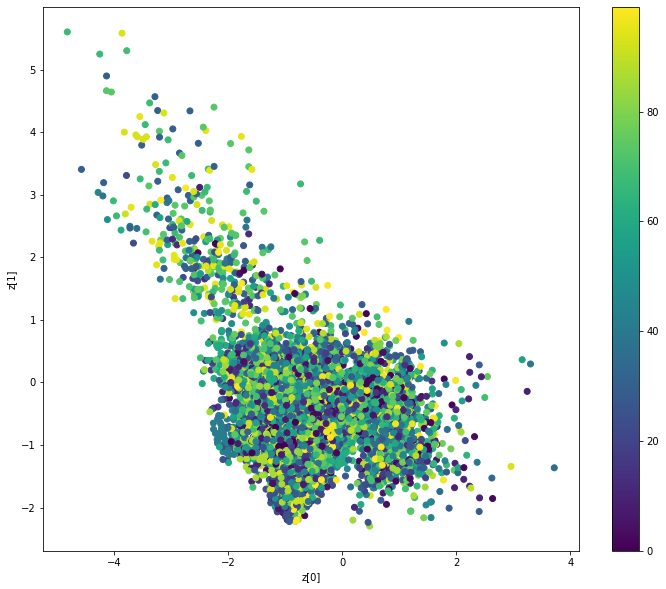

1/1 [==============================] - 0s 26ms/step


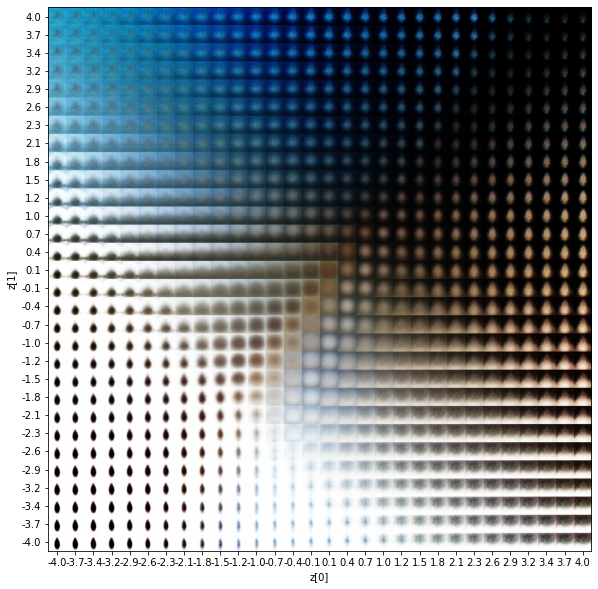

In [28]:
plot_results(encoder, decoder, x_test, y_test, batch_size=batch_size)